# We pre-train BERT on domain specific area (litterature)

Fine-tuning the core leverages two tasks:
- Next Sentence Prediction
- Masked Language Modeling

## 1. NSP
[CLS] BERT output token is feeded to a dense NN layer that output two nodes that pass through a softmax.

Our dataset is a paired dataset

## 2. MLM

We mask 15% of one document, and we try to predict every tokens from the document. 
The MLM head is a feed forward NN that output logit of dimension (vocab_size)

In [ ]:
import sys
sys.path.insert(0, '/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend')

from nlp_recommend.utils.load_data import LoadData
# corpus = LoadData(random=True, max_prcs=6, char_max=15)
# corpus.load_and_clean()
corpus = LoadData(cache=True, dataset='psychology')
corpus_philo = LoadData(cache=True, dataset='philosophy')
corpus.corpus_df = corpus.corpus_df.append(corpus_philo.corpus_df)

In [ ]:
import pandas as pd

df = pd.read_csv(corpus.data_path, lineterminator='\n')
df.loc[:10]

# For each author we want a pair of sentence

In [3]:
# Create a NSP dataset 50% random pair, 50% correct pairs

In [4]:
import random

is_next_pair_df = pd.DataFrame(columns=df.columns)

while len(is_next_pair_df) < len(df)//100:
    # Take a random index
    i = random.randint(0, len(df)-1)
    auth = df.loc[i].author
    title = df.loc[i].title
    next_auth = df.loc[i+1].author
    if auth == next_auth:
        pair = [df.loc[i].sentence, df.loc[i+1].sentence]
        is_next_pair_df = is_next_pair_df.append(pd.DataFrame({'sentence':[pair], 'label': 0, 'title': title}),
                                     ignore_index=True)
is_next_pair_df

,title,author,sentence,label
0,Dream Psychology: Psychoanalysis for Beginners,NaN,[Clearly these desires and needs which agitate...,0.0
1,Dreams,NaN,"[On the other hand, our nocturnal sensations r...",0.0
2,Memoirs of Extraordinary Popular Delusions — V...,NaN,[Every other point of belief was in dispute bu...,0.0
3,Three Contributions to the Theory of Sex,NaN,[A good part of the symptomatology of the neur...,0.0
4,"Criminal Psychology: A Manual for Judges, Prac...",NaN,[These are first of all purely physiological s...,0.0
...,...,...,...,...
297,"Criminal Psychology: A Manual for Judges, Prac...",NaN,[I cannot omit recalling in this place a case ...,0.0
298,Unconscious Memory,NaN,[ it is in respect of these instincts therefor...,0.0
299,Memoirs of Extraordinary Popular Delusions — V...,NaN,[ cooped up and caged then shall the lion ...,0.0
300,"Criminal Psychology: A Manual for Judges, Prac...",NaN,[At this time then the danger that the young g...,0.0


In [5]:
is_next_pair_df.sentence[0]

['Clearly these desires and needs which agitate him are hindrances to sleep.\' "every one knows the charming story of the bad boy (baldwin groller\'s)" \'who awoke at night bellowing out "_i want the rhinoceros_." a really good boy instead of bellowing would have _dreamt_ that he was playing with the rhinoceros',
 'Because the dream which realizes his desire is believed during sleep it removes the desire and makes sleep possible']

In [6]:
is_not_next_pair_df = pd.DataFrame(columns=df.columns)

while len(is_not_next_pair_df) < len(df)//100:
    # Take a random index
    i = random.randint(0, len(df)-1)
    i_nxt = random.randint(0, len(df)-1)
    auth = df.loc[i].author
    title = df.loc[i].title
    next_auth = df.loc[i_nxt].author
    if not (auth == next_auth):
        pair = [df.loc[i].sentence, df.loc[i_nxt].sentence]
        is_not_next_pair_df = is_not_next_pair_df.append(pd.DataFrame({'sentence':[pair], 'label': 1, 'title': title}),
                                     ignore_index=True)
is_not_next_pair_df

,title,author,sentence,label
0,"Criminal Psychology: A Manual for Judges, Prac...",NaN,[Contrast (because every image involves opposi...,1.0
1,The Science of Human Nature: A Psychology for ...,NaN,[(3) parents must help children to plan their ...,1.0
2,A Study of Association in Insanity,NaN,[Citizen--tramp........19 foot--arm..............,1.0
3,Psychotherapy,NaN,[First we have everywhere with us the fact tha...,1.0
4,Psychotherapy,NaN,[The work which the scholar undertakes should ...,1.0
...,...,...,...,...
297,Our Nervous Friends — Illustrating the Mastery...,NaN,"[Jan, the valet never argued urged suggested--...",1.0
298,Unconscious Memory,NaN,[ at this time i had a visit from a friend who...,1.0
299,"Criminal Psychology: A Manual for Judges, Prac...",NaN,[If we pursue our tasks earnestly we draw from...,1.0
300,Unconscious Memory,NaN,[If then the student of nervous physiology tak...,1.0


In [7]:
is_not_next_pair_df

,title,author,sentence,label
0,"Criminal Psychology: A Manual for Judges, Prac...",NaN,[Contrast (because every image involves opposi...,1.0
1,The Science of Human Nature: A Psychology for ...,NaN,[(3) parents must help children to plan their ...,1.0
2,A Study of Association in Insanity,NaN,[Citizen--tramp........19 foot--arm..............,1.0
3,Psychotherapy,NaN,[First we have everywhere with us the fact tha...,1.0
4,Psychotherapy,NaN,[The work which the scholar undertakes should ...,1.0
...,...,...,...,...
297,Our Nervous Friends — Illustrating the Mastery...,NaN,"[Jan, the valet never argued urged suggested--...",1.0
298,Unconscious Memory,NaN,[ at this time i had a visit from a friend who...,1.0
299,"Criminal Psychology: A Manual for Judges, Prac...",NaN,[If we pursue our tasks earnestly we draw from...,1.0
300,Unconscious Memory,NaN,[If then the student of nervous physiology tak...,1.0


In [8]:
# Now we want to create a dataset where isNextSentence (label:0) and IsNotNextSentence (label:1) is 50/50
sentence_a, sentence_b, labels_nsp = [], [], []
for i, sent, in enumerate(is_not_next_pair_df.sentence.values):
    if random.random() > 0.5:
        #This is next sentence
        sentence_a.append(is_next_pair_df.iloc[i].sentence[0])
        sentence_b.append(is_next_pair_df.iloc[i].sentence[1])
        labels_nsp.append(0)
    else:
        #This is next sentence
        sentence_a.append(is_not_next_pair_df.iloc[i].sentence[0])
        sentence_b.append(is_not_next_pair_df.iloc[i].sentence[1])
        labels_nsp.append(1)

In [9]:
for i in range(3):
    print('a --', sentence_a[i])
    print('b --', sentence_b[i])
    print('labels --', labels_nsp[i])

a -- Clearly these desires and needs which agitate him are hindrances to sleep.' "every one knows the charming story of the bad boy (baldwin groller's)" 'who awoke at night bellowing out "_i want the rhinoceros_." a really good boy instead of bellowing would have _dreamt_ that he was playing with the rhinoceros
b -- Because the dream which realizes his desire is believed during sleep it removes the desire and makes sleep possible
labels -- 0
a -- (3) parents must help children to plan their lives in general and in detail; _i.e._ in the sense of determining the ideals and habits that will be necessary for those lives
b -- During the progress of this famous bubble england presented a singular spectacle
labels -- 1
a -- Every other point of belief was in dispute but that was considered by every sect to be as well established as the authenticity of the scriptures or the existence of a god
b -- But at this early period of the epidemic the persecutions were directed by the heads of the catho

2162


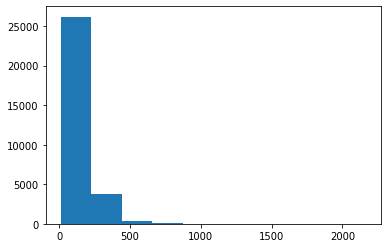

In [10]:
import matplotlib.pyplot as plt

# Max string lenght

plt.hist(df.sentence.map(len))
print(df.sentence.map(len).max())

In [11]:
sentences = df.sentence.values

In [12]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
model_name = 'sentence-transformers/paraphrase-mpnet-base-v2'

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True, sep_token='[SEP]', pad_token='[PAD]', cls_token='[CLS]')

Loading BERT tokenizer...


In [13]:
# Print the original sentence.
print(' Original: ',  sentence_a[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentence_a[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence_a[0])))

 Original:  Clearly these desires and needs which agitate him are hindrances to sleep.' "every one knows the charming story of the bad boy (baldwin groller's)" 'who awoke at night bellowing out "_i want the rhinoceros_." a really good boy instead of bellowing would have _dreamt_ that he was playing with the rhinoceros
Tokenized:  ['clearly', 'these', 'desires', 'and', 'needs', 'which', 'ag', '##itate', 'him', 'are', 'hind', '##rance', '##s', 'to', 'sleep', '.', "'", '"', 'every', 'one', 'knows', 'the', 'charming', 'story', 'of', 'the', 'bad', 'boy', '(', 'baldwin', 'gr', '##oll', '##er', "'", 's', ')', '"', "'", 'who', 'awoke', 'at', 'night', 'bell', '##owing', 'out', '"', '_', 'i', 'want', 'the', 'rhino', '##cer', '##os', '_', '.', '"', 'a', 'really', 'good', 'boy', 'instead', 'of', 'bell', '##owing', 'would', 'have', '_', 'dream', '##t', '_', 'that', 'he', 'was', 'playing', 'with', 'the', 'rhino', '##cer', '##os']
Token IDs:  [4419, 2126, 14718, 2002, 3795, 2033, 12947, 17574, 2036, 

In [14]:
# special input_ids are 
# 0 start sentence a [CLS]
# 2 end of one sentence [SEP]
# 1 padding [PAD]
tokenizer(
                        sentence_a[0], 
                        sentence_b[0], # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

{'input_ids': tensor([[    0,  4419,  2126, 14718,  2002,  3795,  2033, 12947, 17574,  2036,
          2028, 17670, 21625,  2019,  2004,  3641,  1016,  1009,  1004,  2300,
          2032,  4286,  2000, 11955,  2470,  2001,  2000,  2923,  2883,  1010,
         10974, 24669, 14515,  2125,  1009,  1059,  1011,  1004,  1009,  2044,
         19183,  2016,  2309,  4334, 14142,  2045,  1004,  1039,  1049,  2219,
          2000, 24095, 17123,  2895,  1039,  1016,  1004,  1041,  2432,  2208,
          2883,  2616,  2001,  4334, 14142,  2056,  2035,  1039,  3963,  2106,
          1039,  2012,  2006,  2005,  2656,  2011,  2000, 24095, 17123,  2895,
             2,  2142,  2000,  3963,  2033, 10923,  2014,  4796,  2007,  3377,
          2080,  3641,  2013, 20366,  2000,  4796,  2002,  3088,  3641,  2829,
             2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [15]:
len(is_next_pair_df.sentence.values), len(is_not_next_pair_df.sentence.values) 

(302, 302)

In [16]:
import torch
import tqdm 

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_list = []
attention_masks = []
token_type_ids = []

# For every sentence...
# `encode_plus` will:
#   (1) Tokenize the sentence.
#   (2) Prepend the `[CLS]` token to the start.
#   (3) Append the `[SEP]` token to the end.
#   (4) Map tokens to their IDs.
#   (5) Pad or truncate the sentence to `max_length`
#   (6) Create attention masks for [PAD] tokens.
encoded_dict = tokenizer(
                    sentence_a, 
                    sentence_b, # Sentence to encode.
                    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                    max_length = 64,           # Pad & truncate all sentences.
                    padding = 'max_length',
                    return_attention_mask = True,   # Construct attn. masks.
                    truncation=True,
                    return_tensors = 'pt',     # Return pytorch tensors.
               )
# Add the encoded sentence to the list.    
input_ids_list.append(encoded_dict['input_ids'])
token_type_ids.append(encoded_dict['token_type_ids'])
# And its attention mask (simply differentiates padding from non-padding).
attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids_list, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
token_type_ids = torch.cat(token_type_ids, dim=0)
labels = torch.cat(input_ids_list, dim=0).detach().clone()
next_sentence_label = torch.LongTensor([labels_nsp]).T
# Print sentence 0, now as a list of IDs.
print('Original: ', sentence_a[0], sentence_b[0])
print('Token IDs:', input_ids[0])
# print('Attention mask:', attention_masks[0])



Original:  Clearly these desires and needs which agitate him are hindrances to sleep.' "every one knows the charming story of the bad boy (baldwin groller's)" 'who awoke at night bellowing out "_i want the rhinoceros_." a really good boy instead of bellowing would have _dreamt_ that he was playing with the rhinoceros Because the dream which realizes his desire is believed during sleep it removes the desire and makes sleep possible
Token IDs: tensor([    0,  4419,  2126, 14718,  2002,  3795,  2033, 12947, 17574,  2036,
         2028, 17670, 21625,  2019,  2004,  3641,  1016,  1009,  1004,  2300,
         2032,  4286,  2000, 11955,  2470,  2001,  2000,  2923,  2883,  1010,
        10974, 24669, 14515,  2125,  1009,  1059,  1011,  1004,  1009,  2044,
        19183,  2016,  2309,     2,  2142,  2000,  3963,  2033, 10923,  2014,
         4796,  2007,  3377,  2080,  3641,  2013, 20366,  2000,  4796,  2002,
         3088,  3641,  2829,     2])


In [17]:
encoded_dict



{'input_ids': tensor([[   0, 4419, 2126,  ..., 3641, 2829,    2],
        [   0, 1010, 1021,  ...,    1,    1,    1],
        [   0, 2300, 2064,  ...,    1,    1,    1],
        ...,
        [   0, 2069, 2061,  ..., 2022, 2529,    2],
        [   0, 2016, 2027,  ...,    2,    1,    1],
        [   0, 2020, 2101,  ...,    1,    1,    1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [18]:
labels

tensor([[   0, 4419, 2126,  ..., 3641, 2829,    2],
        [   0, 1010, 1021,  ...,    1,    1,    1],
        [   0, 2300, 2064,  ...,    1,    1,    1],
        ...,
        [   0, 2069, 2061,  ..., 2022, 2529,    2],
        [   0, 2016, 2027,  ...,    2,    1,    1],
        [   0, 2020, 2101,  ...,    1,    1,    1]])

# MLM

In [19]:
# Masking MLM input ids

# input_ids is label for MLM model
# it is already a tensor
labels = input_ids.detach().clone()

# Array of random float of id shape
rand = torch.rand(input_ids.shape)

# True when not special token and take 15% of the input
mask_arr = (rand < 0.15) * (input_ids != 1) * (input_ids != 2) * (input_ids != 0)

mask_arr[:3]

tensor([[False, False, False, False, False, False, False, False,  True, False,
         False, False, False, False, False,  True, False, False, False, False,
         False, False,  True, False, False,  True,  True, False, False, False,
         False, False, False,  True, False,  True, False, False, False, False,
         False,  True, False, False, False, False, False, False,  True, False,
          True, False, False, False, False, False,  True, False, False, False,
         False, False, False, False],
        [False, False,  True,  True, False, False, False, False, False, False,
         False, False, False, False,  True, False, False, False, False, False,
         False, False, False, False,  True, False, False,  True, False, False,
          True, False, False, False, False, False, False, False, False, False,
         False, False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False

In [20]:
selection = []

for i in range(input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )
selection[:3]

[[8, 15, 22, 25, 26, 33, 35, 41, 48, 50, 56],
 [2, 3, 14, 24, 27, 30, 42],
 [4, 15, 18, 21, 23, 40, 47, 48, 51]]

In [21]:
# Mask the selected 15%
# we don't mask any special token
for i in range(input_ids.shape[0]):
    input_ids[i, selection[i]] = 3

In [22]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce MX150


In [23]:
# Create a pytorch dataset
from torch.utils.data import TensorDataset, random_split

# combine training inputs into Tensor Dataset
dataset = TensorDataset(input_ids, token_type_ids, attention_masks, next_sentence_label, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  271 training samples
   31 validation samples


In [24]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [25]:
print('elt 0 input id: \n', train_dataset[0][0])
print('elt 0 attention mask: \n', train_dataset[0][1])
print('elt 0 label: \n', train_dataset[0][2])


elt 0 input id: 
 tensor([    0, 14903,  2243,  2007,  2002,  2448,     3,  2064,  3061,     3,
         2035,  2198,  2002,  2179,  2004,  4247,  2002,  3157,  2002,  2206,
         8289,  1015, 12275,  2002,  2035,     3,     3,     3,  2208,  2055,
         2081,     3,  2135,  2209,  2218,  1015,  1015,  2034,  3284,  1033,
         2825,  3464,  2021,  2127,     2,  2089,  2001,  2058,  2110,  2027,
         8159,  2771,  3717,  1033,  8104,     3,     3,  4303,  2004,  2472,
         5403, 18894,  2125,     2])
elt 0 attention mask: 
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
elt 0 label: 
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [26]:
from transformers import BertTokenizer, BertForPreTraining, AdamW
import torch

model_name = 'sentence-transformers/paraphrase-mpnet-base-v2'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForPreTraining.from_pretrained(model_name)


You are using a model of type mpnet to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at sentence-transformers/paraphrase-mpnet-base-v2 were not used when initializing BertForPreTraining: ['encoder.layer.1.attention.attn.k.weight', 'encoder.layer.1.attention.LayerNorm.weight', 'encoder.layer.11.attention.attn.o.bias', 'encoder.layer.3.attention.LayerNorm.bias', 'encoder.layer.2.attention.attn.v.bias', 'encoder.layer.3.attention.attn.o.bias', 'encoder.layer.6.attention.attn.o.bias', 'encoder.layer.8.attention.attn.o.bias', 'encoder.layer.9.attention.attn.q.weight', 'encoder.layer.8.attention.attn.k.weight', 'encoder.layer.11.attention.attn.q.bias', 'encoder.layer.5.attention.attn.v.weight', 'encoder.layer.9.attention.LayerNorm.bias', 'encoder.layer.10.attention.attn.q.bias', 'encoder.layer.9.attention.attn.q.bias', 'encoder.layer.11.attention.attn.v.weight', 'encoder.layer.7.attention.at

In [27]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [28]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [29]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [30]:
import time
import numpy as np 

print(device, epochs)
model.cuda()

# Set the seed value all over the place to make this reproducible.
print(device)
model.cuda()
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

activation = torch.nn.Softmax(dim=1)

# Measure the total training time for the whole run.
total_t0 = time.time()


for epoch_i in range(0, epochs):
        # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    loop = tqdm.tqdm(train_dataloader, leave=True)
    
    for batch in loop:
        # input_ids, token_type_ids, attention_masks, next_sentence_label, labels
        b_input_ids = batch[0].to(device)
        b_token_type_ids = batch[1].to(device)
        b_attention_masks = batch[2].to(device)
        b_next_sentence_label = batch[3].to(device)
        b_labels = batch[4].to(device)
        model.zero_grad()        
        
        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the lorequires_gradss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
#         print('DEBUG', len(b_input_ids, b_inputs_ids.shape))
        output = model(b_input_ids, attention_mask=b_attention_masks,
                        token_type_ids=b_token_type_ids,
                        next_sentence_label=b_next_sentence_label,
                        labels=b_labels)
    

       # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        loss = output.loss
#         logits = output.logits
#         logits = torch.max(activation(logits), axis=1).indices

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
        
        
# Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    eval_labels, eval_logits = [], []
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        b_input_ids = batch[0].to(device)
        b_token_type_ids = batch[1].to(device)
        b_attention_masks = batch[2].to(device)
        b_next_sentence_label = batch[3].to(device)
        b_labels = batch[4].to(device)
        model.zero_grad()        
        
        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the lorequires_gradss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
#         print('DEBUG', len(b_input_ids, b_inputs_ids.shape))
        
                
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output = model(b_input_ids, attention_mask=b_attention_masks,
                        token_type_ids=b_token_type_ids,
                        next_sentence_label=b_next_sentence_label,
                        labels=b_labels)
        loss = output.loss
        logits = output.prediction_logits
        logits = torch.max(activation(logits), axis=1).indices

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += np.sum(logits == label_ids) / len(label_ids)
        eval_labels.extend(label_ids)
        eval_logits.extend(logits)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

cuda 2
cuda

======== Epoch 1 / 2 ========
Training...


100%|███████████████████████████████████████████| 34/34 [00:27<00:00,  1.24it/s]



  Average training loss: 8.73
  Training epcoh took: 0:00:28

Running Validation...


/tmp/ipykernel_6678/3144231659.py:186: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  total_eval_accuracy += np.sum(logits == label_ids) / len(label_ids)


  Accuracy: 0.00
  Validation Loss: 7.38
  Validation took: 0:00:01

======== Epoch 2 / 2 ========
Training...


100%|███████████████████████████████████████████| 34/34 [00:28<00:00,  1.20it/s]



  Average training loss: 7.28
  Training epcoh took: 0:00:28

Running Validation...
  Accuracy: 0.00
  Validation Loss: 7.18
  Validation took: 0:00:01

Training complete!
Total training took 0:00:58 (h:mm:ss)


In [32]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_philo_nsp_mlm_2_epochs/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save_philo_nsp_mlm_2_epochs/


('./model_save_philo_nsp_mlm_2_epochs/tokenizer_config.json',
 './model_save_philo_nsp_mlm_2_epochs/special_tokens_map.json',
 './model_save_philo_nsp_mlm_2_epochs/vocab.txt',
 './model_save_philo_nsp_mlm_2_epochs/added_tokens.json')